In [1]:
import sys

sys.path.append('../..')

In [2]:
# Instead of taking 365 standard days or 252 trading days
# in order to get some easy computations for the eqty and df time grids
# I chose to take 360 days of tradings

step = 1/360.

# Moreover, we fix a $\delta$ mpor (margin period of risk) of 5 days (like in the CCP case)
mpor = 5*step

In [3]:
from finance.discountfactor import ConstantRateDiscountFactor 

maturity = 5
r = 0.02

discount = ConstantRateDiscountFactor(r)

In [4]:
import numpy as np
from scipy.stats import norm
from maths.montecarlo.brownianmotion import BrownianMotion

time_grid = BrownianMotion.generate_time_grid(0, maturity, step)

x_0 = [100, 100]
mu_s = [[5], [4]]
sigma_s = [[10], [6]]

correl = [[1, 0], [0, 1]]

b = BrownianMotion(time_grid, x_0, mu_s, sigma_s, correl)
print b.values[:, 0]
print b(0)

[ 100.  100.]
[[ 100.]
 [ 100.]]


In [5]:
from finance.products.european.assetswap import (
    SwapContract,
)

delta = 0.25

swap_dates = SwapContract.generate_payment_dates(0, maturity, delta)
swap = SwapContract(b, discount, swap_dates)
swap2 = SwapContract(b, discount, swap_dates, 1)

price0_0 = swap.price(0.)
price1_0 = swap2.price(0.)

print swap
print swap2

swaps = [swap, swap2]
price0 = [price0_0, price1_0]

print "Price swap0 at t=0 = ",price0_0
print "Price swap1 at t=0 = ",price1_0

Swap contract of maturity T = 5 years, over S^0 with strike K = 104.821, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Swap contract of maturity T = 5 years, over S^1 with strike K = 104.821, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}
Price swap0 at t=0 =  1.13686837722e-13
Price swap1 at t=0 =  1.13686837722e-13


In [6]:
# To delete

swaps[0].underlying(0)

array([[ 100.],
       [ 100.]])

In [7]:
from risk.exposure import NEuropeanQuantileBrownianExposure

exposures = []
for s in swaps:
    index = s.underlying_index
    drift = mu_s[index][0]
    vol = sigma_s[index][0]
    e = NEuropeanQuantileBrownianExposure(s, discount, drift, vol)
    
    exposures.append(e)

In [8]:
p_fixed = [100 for s in swaps]
strikes = [s.strike for s in swaps]

delta_times = [s.delta_time for s in swaps]
discount_factors = [[discount(t) for t in s.pillars[1:]] for s in swaps]

deltas_betas = [np.dot(d, df) for (d, df) in zip(delta_times, discount_factors)]

notionals = np.divide(p_fixed, np.multiply(deltas_betas, strikes))
print "Notionals =",notionals

Notionals = [ 0.2010025  0.2010025]


In [9]:
from finance.portfolio import Portfolio

members_quantities = np.array([[.5, 3],
                              [-.5, 8]])

members_positions = np.multiply(members_quantities, notionals).reshape(members_quantities.shape)
print members_positions

[[ 0.10050125  0.60300751]
 [-0.10050125  1.60802003]]


In [10]:
from finance.portfolio import Portfolio

portfolio = Portfolio(members_positions, swaps, exposures)

print portfolio.weights
print
print .5/3.5, 3./3.5
print .5/8.5, 8./8.5
print
print 0.10050125/(0.10050125+0.60300751), 0.60300751/(0.10050125+0.60300751)
print 0.10050125/(0.10050125+1.60802003), 1.60802003/(0.10050125+1.60802003)

[[ 0.14285714  0.85714286]
 [ 0.05882353  0.94117647]]

0.142857142857 0.857142857143
0.0588235294118 0.941176470588

0.142857140827 0.857142859173
0.0588235283789 0.941176471621


In [11]:
portfolio_at_time_0 = np.dot(members_positions, price0)
print portfolio_at_time_0

[  7.99796868e-14   1.71385043e-13]


In [12]:
exposure_mpor = 1./12
exposure_quantile = 0.99

expo0 = exposures[0](t=1, risk_period=exposure_mpor, conf_level=exposure_quantile)
expo1 = exposures[1](t=1, risk_period=exposure_mpor, conf_level=exposure_quantile)

print "     d=1      |     d=-1"
print "___________________________"
print expo0
print expo1

     d=1      |     d=-1
___________________________
[ 25.98555162 -24.1301513 ]
[ 15.65313507 -14.41628668]


In [13]:
print members_positions[0][0]*expo0[0], members_positions[0][1]*expo1[0]
print members_positions[1][0]*expo0[1], members_positions[1][1]*expo1[0]

2.61158047397 9.4389580445
2.42511041843 25.1705547853


In [14]:
print portfolio.compute_exposure(1, risk_period=exposure_mpor, conf_level=exposure_quantile)

[[  2.61158047   9.43895804]
 [  2.42511042  25.17055479]]


In [15]:
exps = [exposures[0](t=t, risk_period=exposure_mpor, conf_level=0.99) for t in time_grid]

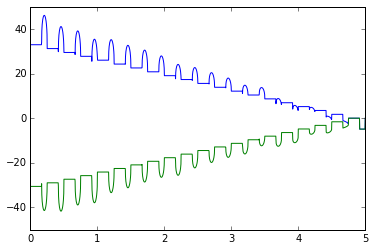

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_grid, exps)
plt.show()

In [17]:
portfolio = Portfolio([[1.]], [swaps[0]], [exposures[0]])

port_exp = [portfolio.compute_exposure(t=t, risk_period=exposure_mpor, conf_level=0.99) for t in time_grid]

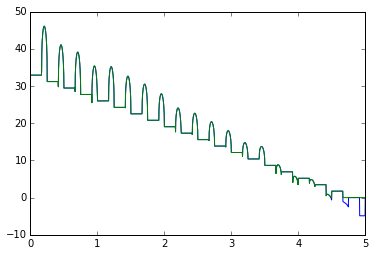

In [18]:
single_expo = [ex[0] for ex in exps]
prt_expo = [p[0, 0] for p in port_exp]

plt.plot(time_grid, single_expo, time_grid, prt_expo)
plt.show()

In [19]:
from finance.portfolio import EquilibratedPortfolio

pos = np.array([[0.5, 3],
                [-0.7, -3],
                [0.2, 0]])

port = EquilibratedPortfolio(pos, swaps, exposures)

In [20]:
try:
    port.compute_exposure_projection(3, 3)
except Exception, e:
    print e

The indexes must be less than 3


In [21]:
print port.compute_exposure_projection(0, 0)
print port.compute_exposure_projection(0, 1)
print port.compute_exposure_projection(0, 2)

[ 0.  0.]
[ 1.  1.]
[ 0.  0.]


In [22]:
print port.compute_exposure_projection(1, 0)
print port.compute_exposure_projection(1, 1)
print port.compute_exposure_projection(1, 2)

[ 0.71428571  1.        ]
[ 0.  0.]
[ 0.28571429  0.        ]


In [23]:
print port.compute_exposure_projection(2, 0)
print port.compute_exposure_projection(2, 1)
print port.compute_exposure_projection(2, 2)

[ 0.  0.]
[ 1.  0.]
[ 0.  0.]
